In [1]:
from dataclasses import dataclass
from typing import Callable
from numbers import Number
import numpy as np
import scipy
from scipy.stats import invgamma, binom, lognorm
from itertools import count, repeat

In [2]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from ipywidgets import IntSlider, interact

In [3]:
def is_numeric(x):
    if isinstance(x, Number):
        return True
    if isinstance(x, np.ndarray):
        return True
    return False

def is_call_or_num(x):
    return is_numeric(x) or callable(x)

def sum_funcs(f, g):
    if not (is_call_or_num(f) and is_call_or_num(g)):
        raise ValueError("f and g are neither functions nor numeric")
    def sum_(x):
        if callable(f) and callable(g):
            return f(x)+g(x)
        if callable(f):
            return f(x)+g
        if callable(g):
            return f+g(x)
        return f+g
    return sum_

def mul_funcs(f, g):
    if not (is_call_or_num(f) and is_call_or_num(g)):
        raise ValueError("f and g are neither functions nor numeric")
    def mul_(x):
        if callable(f) and callable(g):
            return f(x)*g(x)
        if callable(f):
            return f(x)*g
        if callable(g):
            return f*g(x)
        return f*g
    return mul_

@dataclass
class C1Func:
    val: Callable
    grad: Callable
    
    def __add__(self, other):
        if isinstance(other, C1Func):
            return C1Func(val = sum_funcs(self.val, other.val), grad = sum_funcs(self.grad, other.grad))
        if callable(other):
            raise ValueError("Can only sum with other C1Func")
        assert is_numeric(other), "Need %s to be a scalar in order to sum." % other
        # Assume we have a number
        return C1Func(val = sum_funcs(self.val, other), grad = sum_funcs(self.grad, other))
    
    def __radd__(self, other):
        return self.__add__(other)
    
    def __mul__(self, other):
        if isinstance(other, C1Func):
            val = mul_funcs(self.val, other.val)
            grad = sum_funcs(mul_funcs(self.grad, other.val), mul_funcs(self.val, other.grad))
            return C1Func(val = val, grad = grad)
        if callable(other):
            raise ValueError("Can only sum with other C1Func")
        assert is_numeric(other), "Need %s to be a scalar in order to multiply." % other
        # Assume we have a number
        return C1Func(val = mul_funcs(self.val, other), grad = mul_funcs(self.grad, other))
    
    def __rmul__(self, other):
        return self.__mul__(other)
    
    def __neg__(self):
        return -1*self
    
    def __sub__(self, other):
        return self + (-other)
    
    def __rsub__(self, other):
        return -self + other
    
    def map_array(self, *Xs):
        assert len(Xs) > 0, "Need at least one array to apply to."
        _shape = Xs[0].shape
        flat_Xs = [X.reshape(-1) for X in Xs]
        vals = [self.val(np.array(xs)) for xs in zip(*flat_Xs)]
        return np.array(vals).reshape(_shape)

In [4]:
def gaussian_f(m, s=1, h=0, a=1):
    def val(x):
        x_m = x-m
        Nx_m = x_m.dot(x_m)
        return a*np.exp(-Nx_m/(2*(s**2))) + h
    
    def grad(x):
        x_m = x-m
        Nx_m = x_m.dot(x_m)
        return -a*np.exp(-Nx_m/s)*(x-m)/(s**2)
    
    return C1Func(val=val, grad=grad)

loss = -0.5*gaussian_f(np.array([-2,0])) \
    -gaussian_f(np.array([2,-1])) \
    -0.5*gaussian_f(np.array([0,2])) \
    +3*gaussian_f([-4,4],s=.5)


In [5]:
def func_plot(loss, x_lim, y_lim, res=.1, n=100):
    if not res:
        x = np.linspace(x_lim[0], x_lim[1], n)
        y = np.linspace(y_lim[0], y_lim[1], n)
    else:
        x = np.arange(x_lim[0], x_lim[1], res)
        y = np.arange(y_lim[0], y_lim[1], res)
    X, Y = np.meshgrid(x, y)
    Z = loss.map_array(X,Y)
    return X, Y, Z

# Saddle Points and Stochastic Gradient Descent

## Background: Optimizing a loss function:

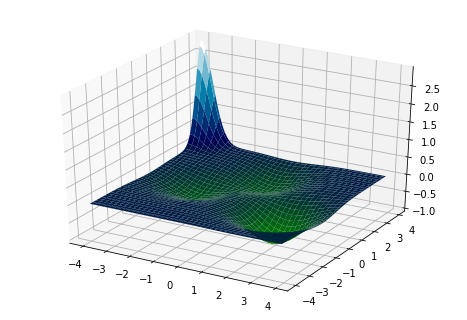

In [6]:
# Plot the loss surface
fig = plt.figure(figsize=(8,5.5))
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(*func_plot(loss, (-4, 4), (-4, 4), n=100), cmap="ocean")
plt.show()

## We use gradient descent:
$$x_n = x_{n-1} - \nabla f$$

In [7]:
rate_decay = .0
lr_0 = 0.001
def sgd(x_0, df, lr_gen=None):
    if lr_gen is None:
        lr_gen = (lr_0/t for t in count(1, rate_decay))
    for lr in lr_gen:
        yield x_0
        delta = df(x_0)
        x_0 = x_0 - lr*delta

In [8]:
def sgd_plot(x_0, loss, lr_gen=None, max_iter=500, bounds=((-4,4), (-4,4))):
    xs = []
    ys = []
    zs = []
    def out_of_bounds(x):
        if x[0] < bounds[0][0] or x[0] > bounds[0][1]:
            return True
        if x[1] < bounds[1][0] or x[1] > bounds[1][1]:
            return True
        return False
    for i, w in enumerate(sgd(x_0, loss.grad, lr_gen)):
        if i > max_iter:
            break
        if out_of_bounds(w):
            break
        X = w[0]
        Y = w[1]
        xs.append(X)
        ys.append(Y)
        zs.append(loss.val(w))
    return xs, ys, zs

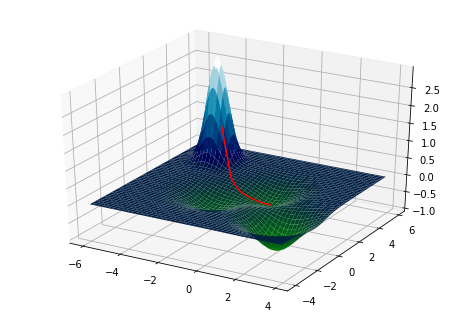

In [9]:
# Plot Gradient Descent on the loss surface
fig = plt.figure(figsize=(8,5.5))
ax = fig.add_subplot(111, projection='3d')

# Plot gradient descent from x0
x0 = np.array([-3.5, 3.51])
ax.plot(*sgd_plot(x0, loss, repeat(.5), 1000, bounds=((-6,4), (-4,6))), color="r")

# Plot the surface
ax.plot_surface(*func_plot(loss, (-6, 4), (-4, 6), n=100), cmap="ocean")
plt.show() 

## What is a saddle point?

A saddle point is a point where a function is locally flat but not a local minima (or maxima).

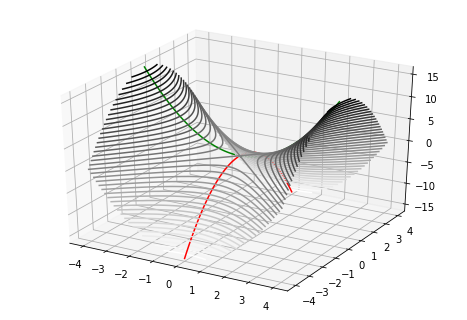

In [10]:
# An example of a saddle point:
fig = plt.figure(figsize=(8,5.5))
ax = fig.add_subplot(111, projection='3d')

# Plot the convex axis:
xs = np.linspace(-4,4, 100)
ys = np.zeros(len(xs))
zs = [x**2 - y**2 for x,y in zip(xs, ys)]
ax.plot(xs, ys, zs, color="g")

# Plot the concave axis:
ys = np.linspace(-4,4, 100)
xs = np.zeros([len(ys)])
zs = [x**2 - y**2 for x,y in zip(xs, ys)]
ax.plot(xs, ys, zs, color="r")

# Make data
x = np.linspace(-4,4, 100)
y = np.linspace(-4,4, 100)
X, Y = np.meshgrid(x, y)
Z = X**2 - Y**2

# Plot the surface
ax.contour3D(X, Y, Z, 50, cmap='binary')

plt.show()

- Saddlepoints always occur between local minima

- There are **lots** of saddle points in deep neural networks

- Locally any saddle point looks like the function 
$$\overset{concave}
{\overbrace{\frac{-a_1}{2}x_1^2+\dots +\frac{-a_k}{2}x_k^2}}
+ \overset{convex}{\overbrace{\frac{a_{k+1}}{2}x_{k+1}^2+\dots+\frac{a_m}{2}x_m^2}}$$
where $1<k<m$ and all $a_i>0$.

### Full Gradient descent will always escape saddle points (eventually) 

Recall the gradient descent formula
$$x_n = x_{n-1} +\Delta x_{n-1}, \quad \text{ where } \quad \Delta x= - \nabla f$$
in coordinates, this reads:
$$\Delta x_i = - \frac{\partial f}{\partial x_i}$$

Meanwhile the local model for a saddle point at the origin is:
$$f(x_1,\dots,x_n) = \overset{concave}
{\overbrace{\frac{-a_1}{2}x_1^2+\dots +\frac{-a_k}{2}x_k^2}}
+ \overset{convex}{\overbrace{\frac{a_{k+1}}{2}x_{k+1}^2+\dots+\frac{a_m}{2}x_m^2}}$$

We have 
$$\frac{\partial f}{\partial x_i} = -a_ix_i\quad \text{ for } i<=k\quad\quad
\text{ and }\quad\quad\frac{\partial f}{\partial x_i} = a_ix_i\quad \text{ for } i>k$$

So:
    $$\Delta x_i = a_ix_i \quad \text{ for } i<=k \quad \text{ (repulsive dynamics)}$$
and
$$\Delta x_i = -a_ix_i \quad \text{ for } i>k \quad \text{ (attractive dynamics)}$$

Though we are attracted to the saddle point in some directions, we are eventually ejected from the saddle point by the repulsive forces.

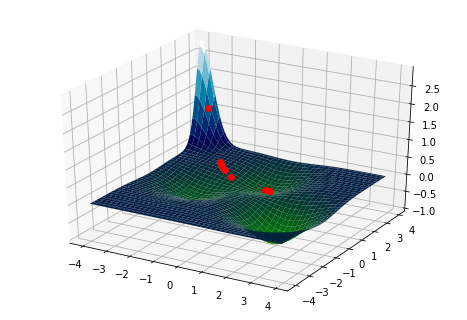

In [11]:
# Gradient Descent can get stuck near saddle points
fig = plt.figure(figsize=(8,5.5))
ax = fig.add_subplot(111, projection='3d')

# Plot gradient descent from x0
skip = 20
x0 = np.array([-3.5, 3.51])
xs, ys, zs = sgd_plot(x0, loss, repeat(.5), 1000)
ax.plot(xs[::skip], ys[::skip], zs[::skip], "bo", color="r",)

# Plot the surface
ax.plot_surface(*func_plot(loss, (-4, 4), (-4, 4), n=100), cmap="ocean")
plt.show() 

## Typically, the loss function in deep neural networks is noisy
- Deep networks need massive data sets to train successfully
- One needs to train the network on smaller minibatches of the data
- One samples these minibatches from the known data and this sampling results in a **noisy loss function** 


In [12]:
def noisy_surface(intensity=2):
    def f(x):
        return x[0]**4/4 - x[0]**3 + x[0] + x[1]**2
    
    def df(x):
        a_0, a_1 = np.random.normal(loc=0, scale = intensity, size=2)
        X = x[0]+a_0
        Y = x[1]+a_1
        return np.array([X**3 + -3*X**2 + 1, 2*Y])

    rate_decay = .0001
    lr_0 = 0.001
    return {
        "c1f": C1Func(val=f, grad=df),
        "lr_gen": (lr_0/t for t in count(1, rate_decay)),
        "x0": [2,-3],
        "max_iter": 1000
    }

## Example:

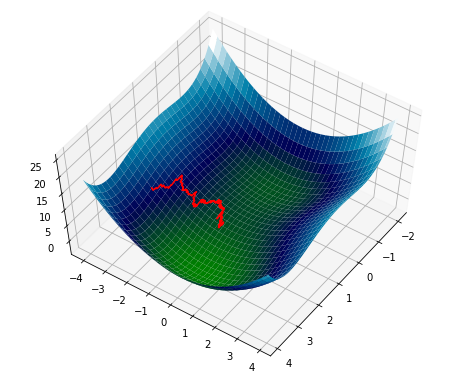

In [13]:
# Plot Gradient Descent on the loss surface
intensity=2 # 0, 1, 2

# get the noisy surface:
ns = noisy_surface(intensity)

# Set up the plotting environment
fig = plt.figure(figsize=(8,6.6))
ax = fig.add_subplot(111, projection='3d')

# Plot gradient descent from x0
ax.plot(*sgd_plot(ns["x0"], ns["c1f"], ns["lr_gen"], ns["max_iter"]), color="r")

# Plot the surface
ax.plot_surface(*func_plot(ns["c1f"], (-2, 4), (-4, 4), n=100), cmap="ocean")
ax.view_init(60, 35)
plt.show() 

## Overview of talk:
- I will describe why noise can trap us at saddle points
- I will describe some ways to escape saddle points
- Open questions

## Why noise hurts

The local model for a saddle point in a noisy loss function:
$$f(x_1,\dots,x_n) = \overset{concave}
{\overbrace{\frac{-a_1-\xi_1}{2}x_1^2+\dots +\frac{-a_k-\xi_k}{2}x_k^2}}
+ \overset{convex}{\overbrace{\frac{a_{k+1}-\xi_{k+1}}{2}x_{k+1}^2+\dots+\frac{a_m-\xi_m}{2}x_m^2}}\\
-\eta_1x_1-\cdots-\eta_mx_m
$$
where $\xi_i$ and $\eta_i$ are **noise** (mean zero random variables).

So, we have 
$$\frac{\partial f}{\partial x_i} = \pm a_ix_i +\xi_ix_i+\eta_i$$
And the gradient descent update becomes:
$$\Delta x_i =\pm a_i x_i+ \xi_i x_i+\eta_i$$

Let's consider the seperate components
    $$ \Delta x =
    \overset{\text{Usual gradient}}{\overbrace{\pm ax}} 
    +\overset{\text{Attractive noise}}{\overbrace{\xi x}}+\overset{\text{Diffusive noise}}{\overbrace{\eta}}$$

## Attractive noise:
$$x_{n+1}=(1+\xi) x_{n}$$

Suppose that either $\xi =-\sigma$ or $\xi= \sigma$ with equal probability.

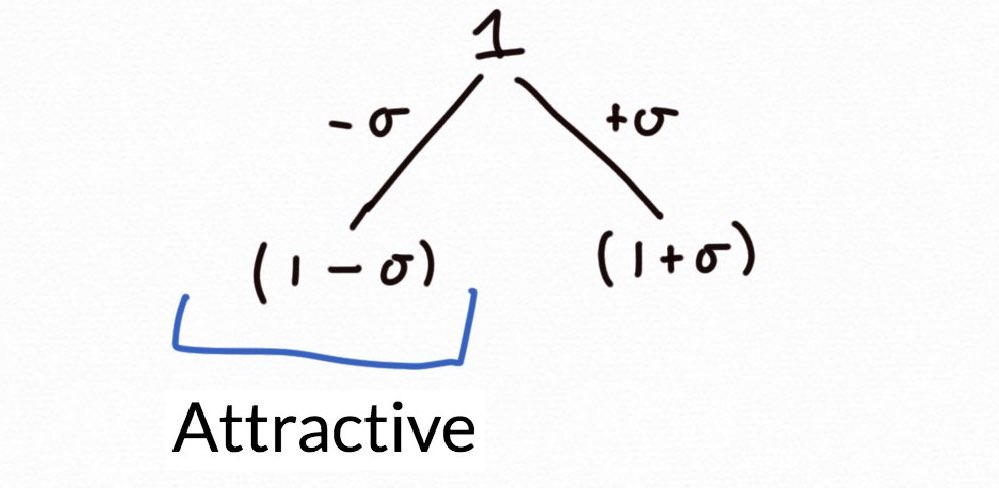

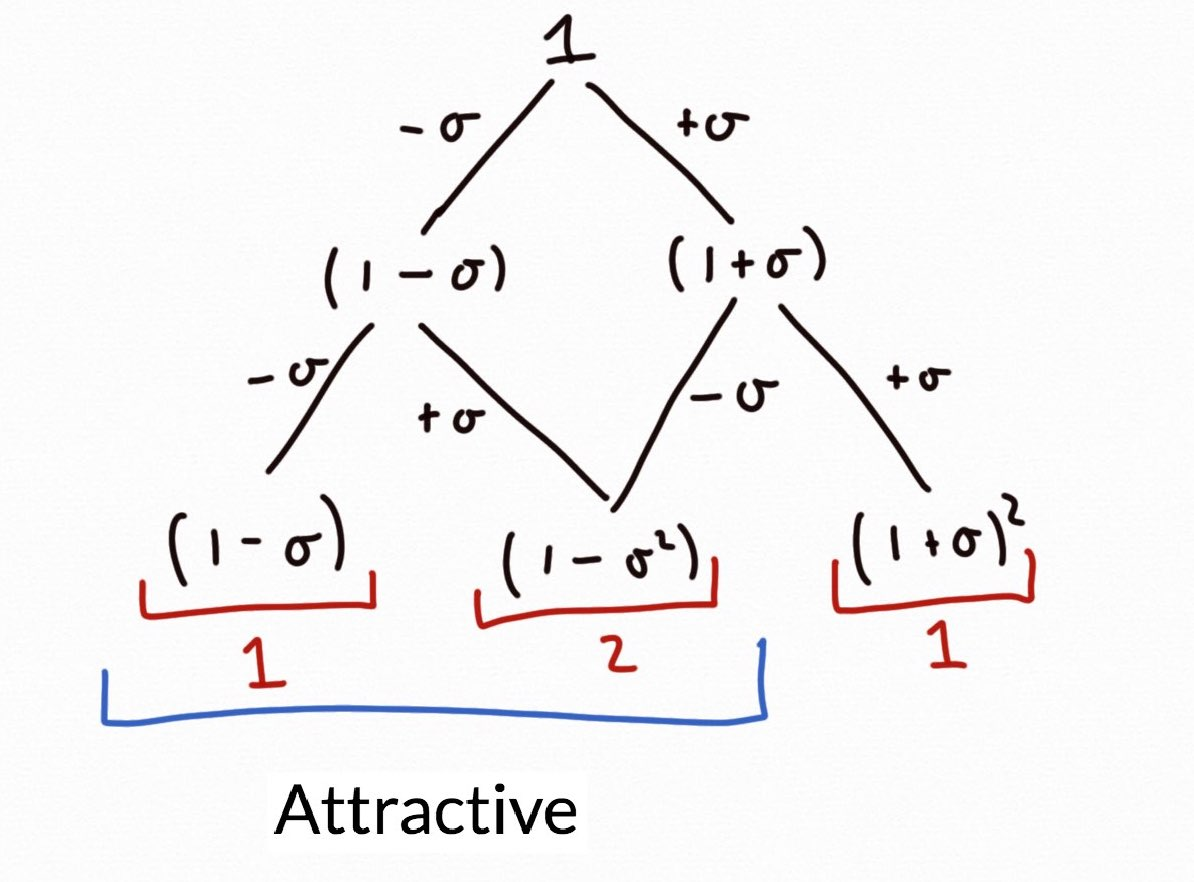

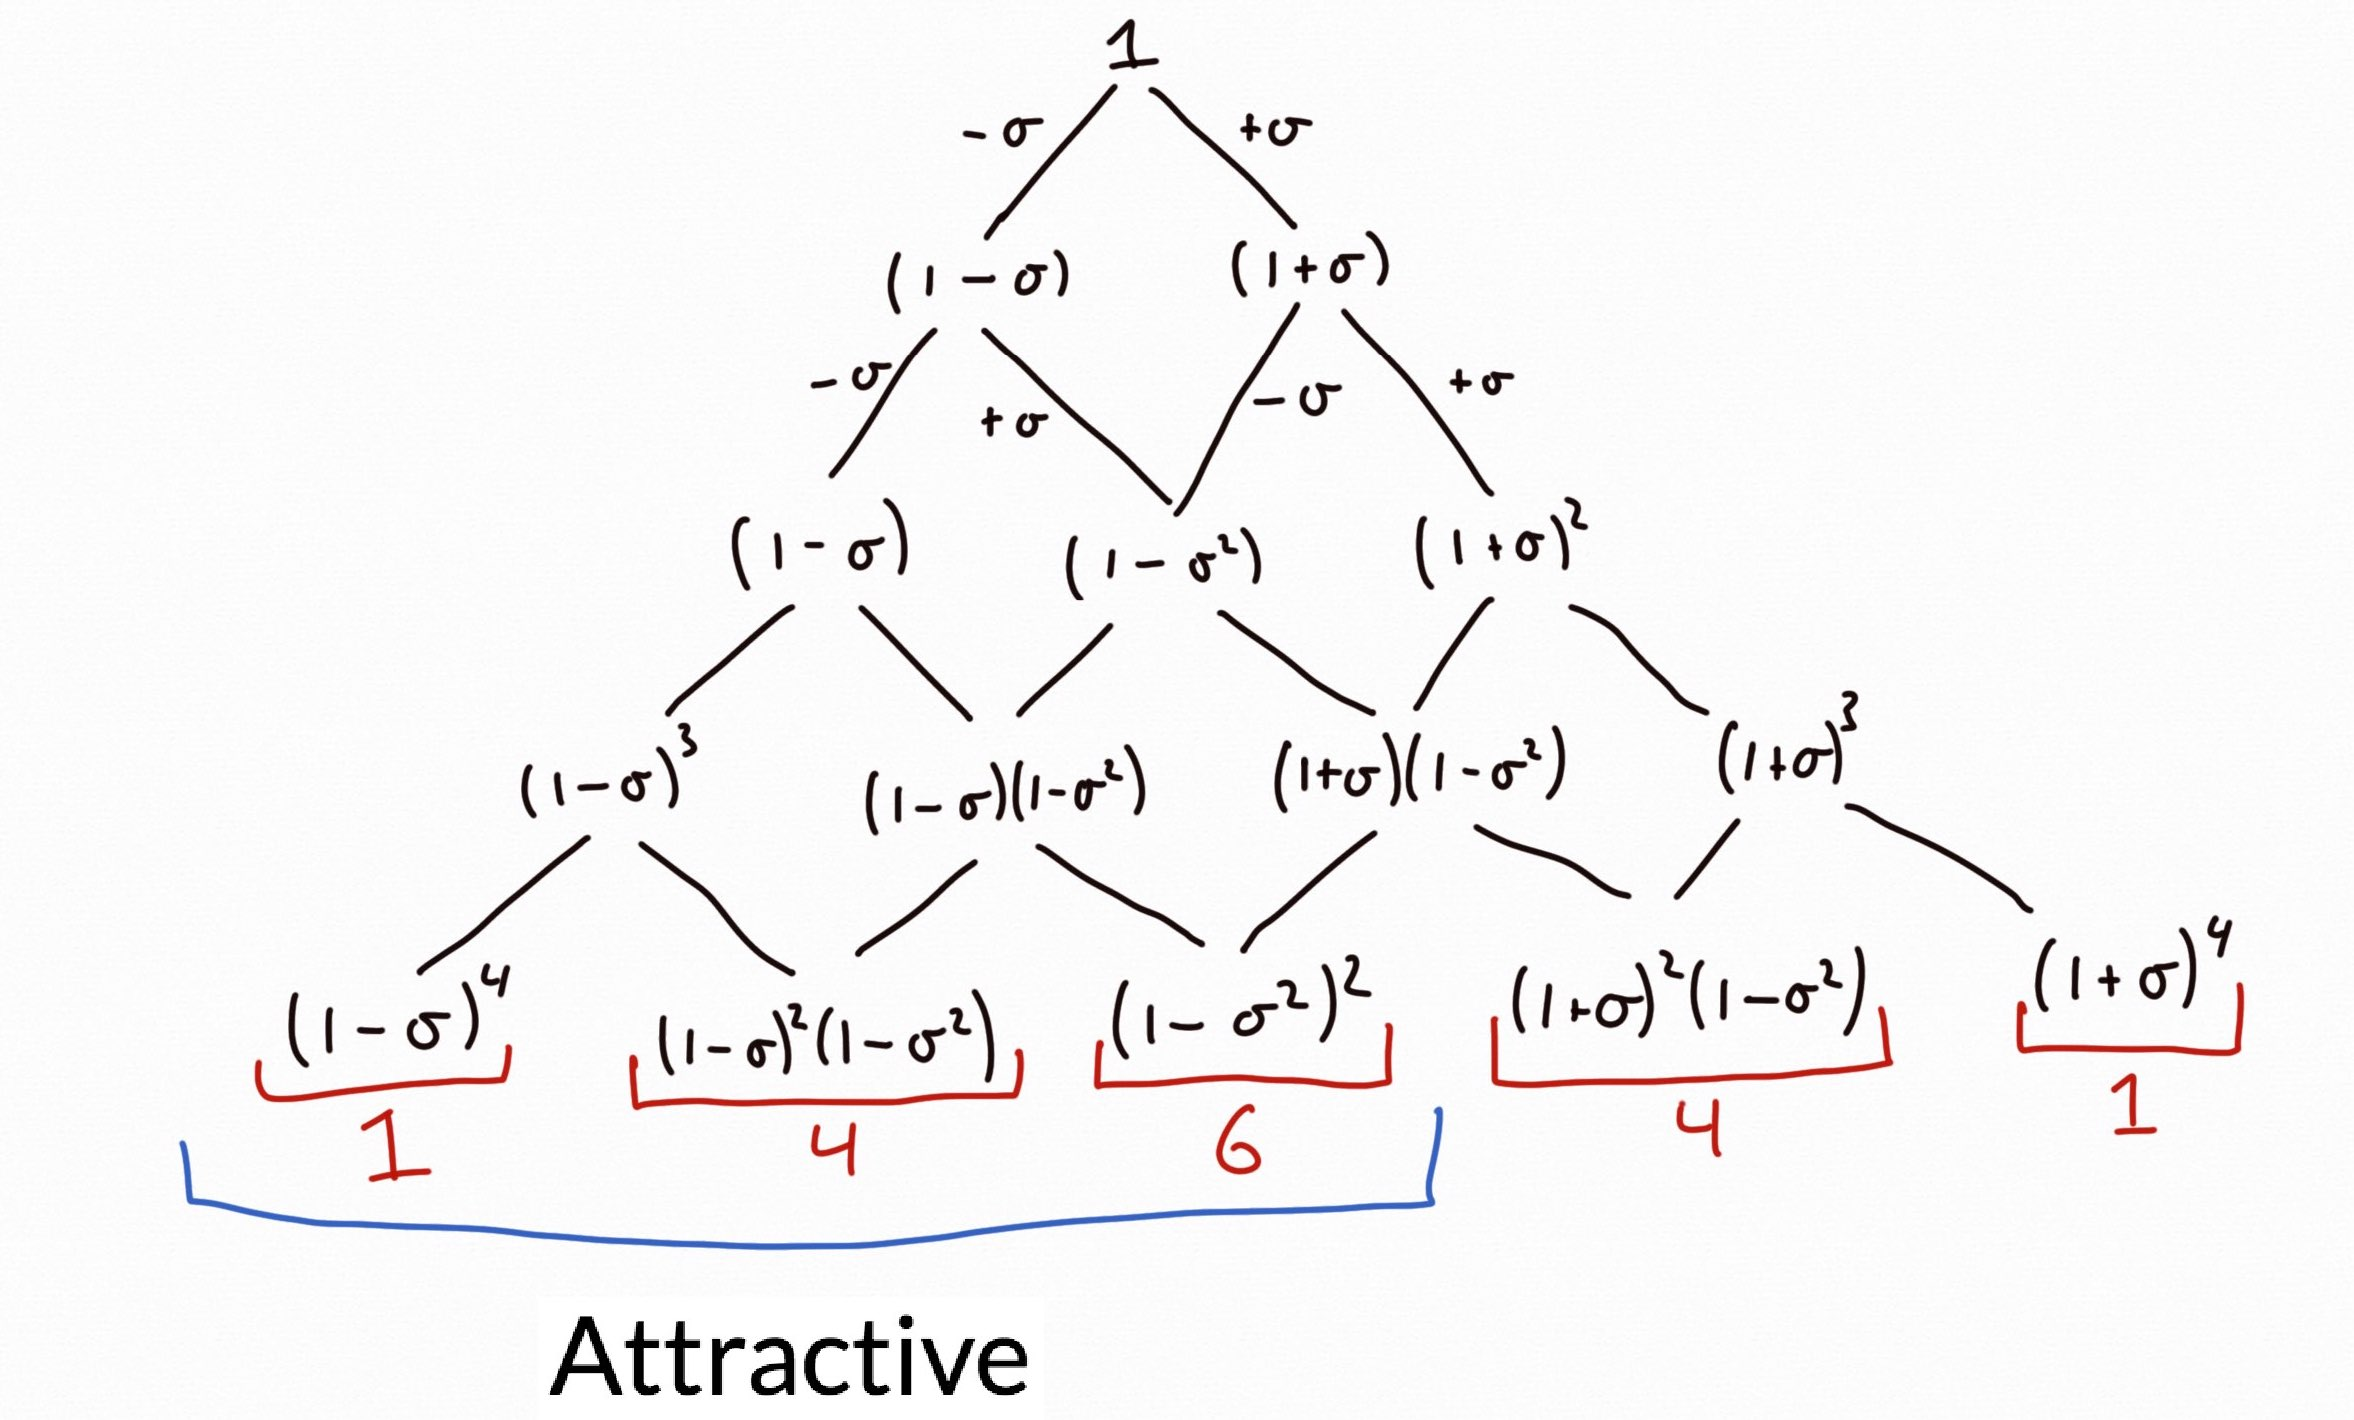

In [14]:
def attractive_boundary(N,sigma):
    P = lognorm.cdf(1, scale = np.exp(-N*sigma**2/2), s=sigma*np.sqrt(N))
    return binom.ppf(P, N, 0.5)

def draw_binom(ax, N, sigma, L, R, color):
    x = np.arange(L, R+1)
    ax.plot(x, binom.pmf(x, N, 0.5), color+"o", ms=8, label="binom pmf")
    ax.vlines(x, 0, binom.pmf(x, N, 0.5), colors=color, lw=5, alpha=0.5)

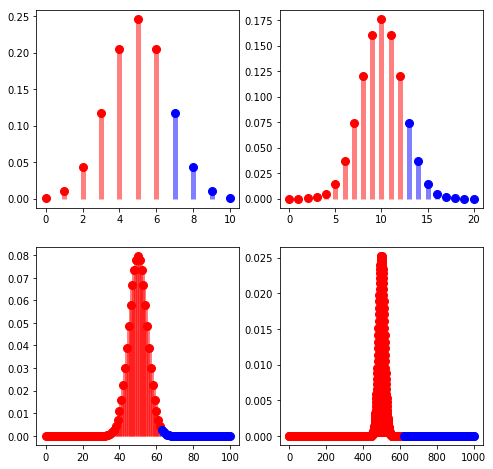

In [15]:
# Stage N
N = 10
sigma=0.1

fig, ax = plt.subplots(2, 2, figsize=(8,8))
N = 10
N_A = attractive_boundary(N, 0.5)
draw_binom(ax[0,0], N, sigma, 0, N_A, "r")
draw_binom(ax[0,0], N, sigma, N_A+1, N, "b")

N_A = attractive_boundary(N, 0.5)
N = 20
N_A = attractive_boundary(N, 0.5)
draw_binom(ax[0,1], N, sigma, 0, N_A, "r")
draw_binom(ax[0,1], N, sigma, N_A+1, N, "b")

N_A = attractive_boundary(N, 0.5)
N = 100
N_A = attractive_boundary(N, 0.5)
draw_binom(ax[1,0], N, sigma, 0, N_A, "r")
draw_binom(ax[1,0], N, sigma, N_A+1, N, "b")

N_A = attractive_boundary(N, 0.5)
N = 1000
N_A = attractive_boundary(N, 0.5)
draw_binom(ax[1,1], N, sigma, 0, N_A, "r")
draw_binom(ax[1,1], N, sigma, N_A+1, N, "b")

# Diffusive noise:
Recall:
    $$ \Delta x =
    \overset{\text{Usual gradient}}{\overbrace{\pm ax}} 
    +\overset{\text{Attractive noise}}{\overbrace{\xi x}}+\overset{\text{Diffusive noise}}{\overbrace{\eta}}$$
    
So the diffusive component is:
    $$ \Delta x = \eta$$
    
At stage $N$, we have
$$x_N=x_0+\sum_{n=0}^N \Delta x_n = x_0+\sum_{i=0}^N \eta_i$$

But $\eta_i$ are iid random variables with mean zero and norm $\tau$, so $\sum_{i=0}^N \eta_i\sim N(0, \sqrt{N}\tau)$. Therefore:

$$x_N\sim N(x_0, \tau\sqrt{N})$$

In summary, $x$ diffuses at a rate of $\tau\sqrt{N}$.

## Does the diffusive or attractive noise dominate?

$$ \Delta x =
    \overset{\text{Usual gradient}}{\overbrace{\pm ax}} 
    +\overset{\text{Attractive noise}}{\overbrace{\xi x}}+\overset{\text{Diffusive noise}}{\overbrace{\eta}}$$
    
#### Replace with a stochastic differential equation:

$$dx = ax \:dt+\xi x \:dt +\eta\: dt$$
where $\xi$ and $\eta$ are white noise.

Let $\sigma$ and $\tau$ represent the scaling factors such that 
$W_t=\int_0^t\frac{\xi}{\sigma}\:dt$ and $V_t=\int_0^t\frac{\eta}{\tau}\:dt$ are standard brownian motion. Then

$$dx = ax \:dt+\sigma x \:dW +\tau\: dV$$

## Case 1: $\xi$ and $\eta$ are correlated

In this case we may assume $V = W$, so
$$dx = ax \:dt+\sigma x \:dW +\tau\: dW$$
Substituting $x = y-\tau/\sigma$, we get
$$dy = a(y-\tau/\sigma) \:dt  + \sigma y \:dW$$

This elimates the diffusive noise, replacing it by a constant rate of change of $-a\tau/\sigma$. We can solve this exactly, to get:
$$x_t = -\tau/\sigma+(x_0+\tau/\sigma)e^{(a-\sigma^2/2)t+\sigma W_t}-\frac{a\tau}{\sigma}\int_0^t e^{(a-\sigma^2/2)(t-s)+\sigma (W_t-W_s)}ds$$

$$x_t = -\tau/\sigma+(x_0+\tau/\sigma)e^{(a-\sigma^2/2)t+\sigma W_t}-\frac{a\tau}{\sigma}\int_0^t e^{(a-\sigma^2/2)(t-s)+\sigma (W_t-W_s)}ds$$

We see that the effective rate of growth is $a-\sigma^2/2$
- this rate depends only on the intensity of the attractive noise.
    - It is independent of the intensity of the diffusive noise.
- In particular, if the noise $\sigma$ is sufficiently strong, the saddle point will be attractive.

## Stationary distribution:

$$\lim_{t\to \infty} -x_t-\tau/\sigma$$ 
is inverse-gamma distributed with scale $\beta = 2\frac{\lvert a\tau\rvert}{\sigma^3}$ and shape $\alpha = 1-2a/\sigma^2$



This has no mean, but it's mode is at $-\tau/\sigma+\beta/(\alpha+1)= -\tau/\sigma-\frac{a\tau}{\sigma^3-a\sigma}$

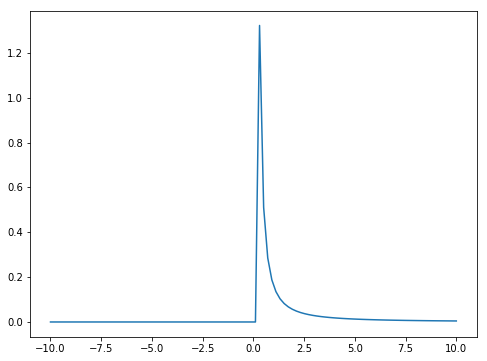

In [4]:
# The stationary distribution
a, sig, tau = 1, 2, -.25

alpha = 1-2*a/(sig**2)
beta = 2*abs(a*tau)/(sig**3)
rv = invgamma(alpha, loc = abs(tau/sig), scale=beta)

fig, ax = plt.subplots(1, 1, figsize=(8,6))
x_tmp = np.linspace(-10,10, 100)
ax.plot(x_tmp, rv.pdf(x_tmp if a*tau <0 else x_tmp[-1::-1]))
plt.show()

In [25]:
(tau*sig)/(a-sig**2)

0.16666666666666666

In [26]:
n = 5000
dt = 1

In [27]:
samples = 3000
white_noise = np.random.normal(loc=0, scale=np.sqrt(dt), size = (n, samples))/dt
W = np.cumsum(dt*white_noise[:,:], axis = 0)

In [28]:
s = np.arange(0, n*dt, dt).reshape([n,1])
T = n*dt
X = -tau/sig-a*tau/sig*np.cumsum(dt*np.exp((a-(sig**2)/2)*(T - s) + sig*(W[-1,:] - W)), axis = 0)

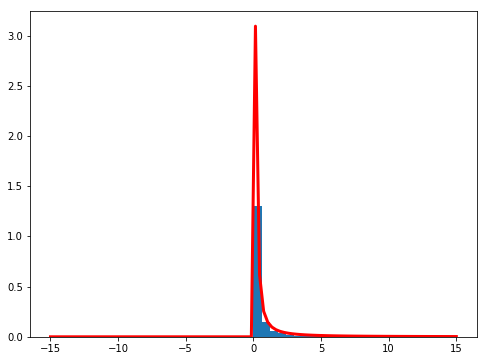

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.hist(X[-1,:], bins=50, density=True, range=(-15,15))
x_tmp = np.linspace(-15,15, 100)
ax.plot(x_tmp, rv.pdf(x_tmp if a*tau <0 else x_tmp[-1::-1]), color="r", linewidth=3)
plt.show()

/Users/libland/miniconda3/envs/scipy/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: overflow encountered in multiply
/Users/libland/miniconda3/envs/scipy/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in add
/Users/libland/miniconda3/envs/scipy/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: overflow encountered in add
/Users/libland/miniconda3/envs/scipy/lib/python3.6/site-packages/numpy/lib/function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/libland/miniconda3/envs/scipy/lib/python3.6/site-packages/numpy/lib/function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/Users/libland/miniconda3/envs/scipy/lib/python3.6/site-packages/numpy/lib/function_base.py:838: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


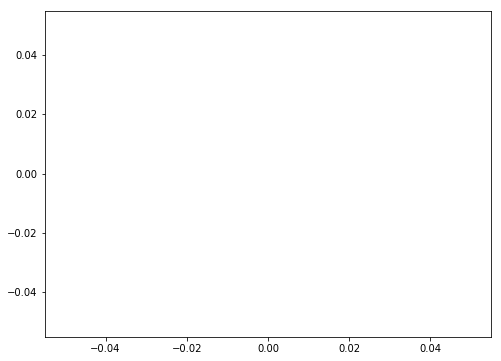

In [30]:
xx = np.zeros([n, samples])
x_0=-25
xx[0,:] = x_0
for i in range(1, n):
    xx[i,:] = (a*xx[i-1,:]+sig*xx[i-1,:]*white_noise[i-1,:]+tau*white_noise[i-1,:])*dt
fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.hist(xx[-1,:], bins=50, density=True, range=(-5,5))
plt.show()

## Case 2: $\xi$ and $\eta$ are *not* correlated
In this case, $\eta$ serves to time-average the solution
$$\hat x_t=x_0e^{(a-\sigma^2/2)t+\sigma W_t}$$
of the equation 
$$d\hat x = a\hat x \:dt+\sigma \hat x \:dW$$
Explictly, we have
$$x_t = x_0e^{(a-\sigma^2/2)t+\sigma W_t} + \int_0^te^{(a-\sigma^2/2)(t-s)+\sigma (W_t-W_s)}\eta \: ds$$

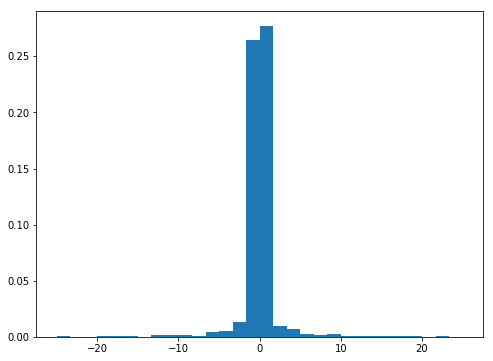

In [31]:
# Sampling from the stationary distribution we get:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
dV = np.random.normal(loc=0, scale=np.sqrt(dt), size = (n, samples))/dt
X = tau*np.cumsum(dV*np.exp((a-(sig**2)/2)*(T - s) + sig*(W[-1,:] - W)), axis = 0)
ax.hist(X[-1,:], bins=30, density=True, range=(-25,25))
plt.show()

## How should we escape saddle points in the presence of noise?

We need to reduce the noise!

## Options
- Perturbed Stochastic Gradient Descent
- Stochastic Variance Reduction Gradient Descent (SVRGD)
- Increase the minibatch size
- Decrease the learning rate
- Anneal the learning rate
- Use ReLu's

## Perturbed Stochastic Gradient Descent

### Idea: 
Increase the intensity of the diffusive noise $\eta$ in the equation 
$$dx = ax \:dt+\xi x \:dt +\eta\: dt$$

### Problems:
- This does not guarantee that we will escape, instead 
    - it increases the odds that we will escape, 
    - it greatly speeds how quickly we pass through non-attractive saddle points (where the attractive noise is small).


## Stochastic Variance Reduction Gradient Descent (SVRGD)
### Idea:
Suppose you have $N$ training samples.

until converged:<br>
$\quad\quad$ store the current location $x$ as a landmark:<br>
$\quad\quad$ set $x_{*} := x$<br>
$\quad\quad$ compute the full gradient $\nabla f_{full}(x_*)$ at $x_*$<br>
$\quad\quad$ for i = 1 ... N:<br>
$\quad\quad\quad\quad$ compute the approximate gradient $\nabla f_{approx}(x)$ at x<br>
$\quad\quad\quad\quad$ compute the approximate gradient $\nabla f_{approx}(x_*)$ at $x_*$<br>
$\quad\quad\quad\quad$ set $\nabla f_{VR} := \nabla f_{approx}(x)-\nabla f_{approx}(x_*)+\nabla f_{full}(x_*)$<br>
$\quad\quad\quad\quad$ set $x := x - \nabla f_{VR}$
    
    

- Interestingly, SVRGD serves correlate the two noises $\xi$ and $\eta$ in the equation $$dx = ax \:dt+\xi x \:dt +\eta\: dt$$
- Infact, at the end of every inner loop $x-x_*$ exhibits an inverse gamma distribution with scale proportionate to the distance from $x_*$ to the saddle point:

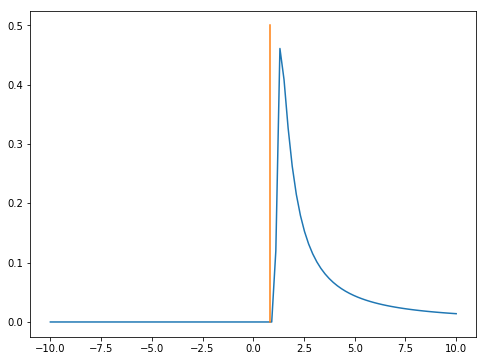

In [4]:
# The stationary distribution
a, sig, tau = 1, 2, -2

x0=abs(tau/sig)
alpha = 1-2*a/(sig**2)
beta = 2*abs(a*tau)/(sig**3)
rv = invgamma(alpha, loc = x0, scale=beta)

fig, ax = plt.subplots(1, 1, figsize=(8,6))
x_tmp = np.linspace(-10,10, 100)
ax.plot(x_tmp, rv.pdf(x_tmp if a*tau <0 else x_tmp[-1::-1]))
# ax.text(abs(tau/sig), .5, "x")
ax.plot([x0-.2,x0-.2],[0,.5])
plt.show()

## SVGRD guarantees that you will escape the saddle point

Infact, you expect to escape geometrically (in the outer loop)

### Problems:
- Unfortuately, you may need to compute the full gradient (updating $x_*$) before each foolproof step away from the saddle point.
- This results in the same computational cost as gradient descent (which is considered too expensive for training deep neural networks).


## Increase the minibatch size

### Idea:
- Full batch Gradient Descent will never get stuck at a saddle point 
    - Why? It reduces the attactive noise to zero
- Similarly, using large minibatches greatly decreases the odds of being stuck at a saddle point 
    - Why? It reduces the attactive noise
    
### Problems:
- Unfortunately using larger minibatches becomes computationally expensive

## Decrease the learning rate

### Idea:
Instead of making the updates $$x_n = x_{n-1} +\Delta x_{n-1},$$ make smaller updates: $$x_n = x_{n-1} +\rho \Delta x_{n-1}$$ (where $0<\rho<1$ is small).

- This decreases the attractive noise by a factor of $\sqrt{\rho}$

### Problems:
- Learning takes longer
- It doesn't guarantee that we will escape, it only increases the odds

## Anneal the learning rate

### Idea:
Decrease the learning rate on a regular schedule:
$$x_n = x_{n-1} +\rho \Delta x_{n-1}$$
$$p_n = \rho_0/n$$

- This **Guarantees** tha we will escape the saddle point (eventually),
- This is recommended for other reasons too

### Problems:
- It may still take too long to escape

## Use ReLu's

### Idea:
- Regularized linear units result in piecewise linear loss functions
- This eliminates the attractive noise in the local update
- It dramatically changes the dynamics

In [ ]:
def PLF(vvs = (((1,1,1), (1,-1,1)),((-1,-1,1),(-1,1,1), (-1, .25, -.5))), sig_0=0, sig=.2):
    """
    Noisy Piecewise Linear Saddle point
    Min Max: Min of the inner elements of vvs, max of the outers
    """
    def noisify_vvs(vvs, sig):
        return [
            [np.array(v)+np.random.normal(loc=0, scale = sig, size=3)
            for v in vs]
            for vs in vvs
        ]
        
    
    def val(x):
        x = np.concatenate([x,[1]])
        return max(
            min(map(lambda v: np.dot(x, v), vs))
            for vs in vvs
        )
    
    def grad(x):
        wws = noisify_vvs(vvs, sig)
        x = np.concatenate([x,[1]])
        loc_vals = [
            [np.dot(x, v) for v in vs]
            for vs in wws
        ]
        o_argmax = np.argmax([max(*val) for val in loc_vals])
        i_argmin = np.argmin(loc_vals[o_argmax])
#         print(o_argmax, i_argmin)
        v = wws[o_argmax][i_argmin]
        return np.array([v[0],v[1]])
    return C1Func(val=val, grad=grad)

In [ ]:
# Plot the loss surface
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection="3d")

lossPLF = PLF(sig=.2)

# Plot gradient descent from x0:
x0 = np.array([-2, .5])
ax.plot(*sgd_plot(x0, lossPLF, repeat(.5), 100), color="r")

# Plot the surface:
ax.plot_surface(*func_plot(lossPLF, (-4, 4), (-4, 4), n=100), cmap="ocean")
plt.show()

## Open questions
- What are the odds of the attractive noise being significantly strong?
    - How is affected by the dimensionality?
        - Is it less likely in high dimensions?
    - How is it affected by depth vs width of the network?
- How does momentum affect the dynamics?
- Trade off between increasing batch size (reduces variance linearly) vs increasing network size (reduces odds of only bad directions, while also increasing number of saddle points).

In [ ]:
plt.savefig?